#MNIST digit recognition using Stochastic Gradient Boosting in **scikit-learn**

#> Find the optimal number of trees on a graph
---

In [1]:
from __future__ import division
import os, time, math
import cPickle as pickle
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import csv

from sklearn.ensemble         import GradientBoostingClassifier

from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import GridSearchCV

from sklearn.metrics          import classification_report, confusion_matrix, f1_score
from sklearn.externals        import joblib

np.random.seed(seed=1009)

%matplotlib inline

In [20]:
#%qtconsole

##Where's the data?

In [3]:
file_path = '../data/'

DESKEWED = True
if DESKEWED:
    train_img_filename = 'train-images_deskewed.csv'
    test_img_filename  = 't10k-images_deskewed.csv'
else:
    train_img_filename = 'train-images.csv'
    test_img_filename  = 't10k-images.csv'
    
train_label_filename = 'train-labels.csv'
test_label_filename  = 't10k-labels.csv'

##How much of the data will we use?

In [4]:
portion = 0.10  # set to 1.0 for all of it

##Read the training images and labels

In [5]:
with open(file_path + train_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainX = np.asarray(data, dtype = np.float64)  

trainX = trainX[:portion*trainX.shape[0]]

print("trainX shape: {0}".format(trainX.shape))

with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainY = np.asarray(data, dtype = np.int8) 

trainY = trainY[:portion*trainY.shape[0]].ravel()

print("trainY shape: {0}".format(trainY.shape))

trainX shape: (6000, 784)
trainY shape: (6000,)


##Read the test images and labels

In [6]:
with open(file_path + test_img_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.asarray(data, dtype = np.float64)  

testX = testX[:portion*testX.shape[0]]

print("testX shape: {0}".format(testX.shape))

with open(file_path + test_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testY = np.asarray(data, dtype = np.int8)

testY = testY[:portion*testY.shape[0]].ravel()

print("testY shape: {0}".format(testY.shape))

testX shape: (1000, 784)
testY shape: (1000,)


#Use the smaller, fewer images for testing

##Function to print a matrix of images

In [7]:
def print_imgs(images, actual_labels, predicted_labels, starting_index = 0, size=6):
    """
    print a grid of images
    showing any differences in predicted values
    
    images           m x 784 array of pixels
    actual_labels    m x 1 array of the actual labels
    predicted_labels m x 1 of predicted labels
    starting_index   scalar, where in 1...m to start
    size             scalar the grid is size x size
    """
    img_dim  = int(pow(images.shape[1],0.5)) # images assumed to be square
    fig, axs = plt.subplots(size,size, figsize=(img_dim,img_dim), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.0001, wspace=.001)
    axs = axs.ravel()
    
    for grid_i, img_i in enumerate(xrange(starting_index, starting_index+(size*size))):
        
        # convert from 1 x flat to img_dim x img_dim
        img = np.reshape(images[img_i,:],(img_dim,img_dim))
        
        axs[grid_i].imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        
        if actual_labels[img_i] != predicted_labels[img_i]:
            axs[grid_i].set_title("actual: {0}; predicted: {1}" \
                                  .format(actual_labels[img_i], predicted_labels[img_i]), 
                                  fontsize=16,
                                  color='r')
        else:
            axs[grid_i].set_title("label: {0}" \
                                  .format(actual_labels[img_i]), 
                                  fontsize=16)
            
    plt.show()

##Print a sample

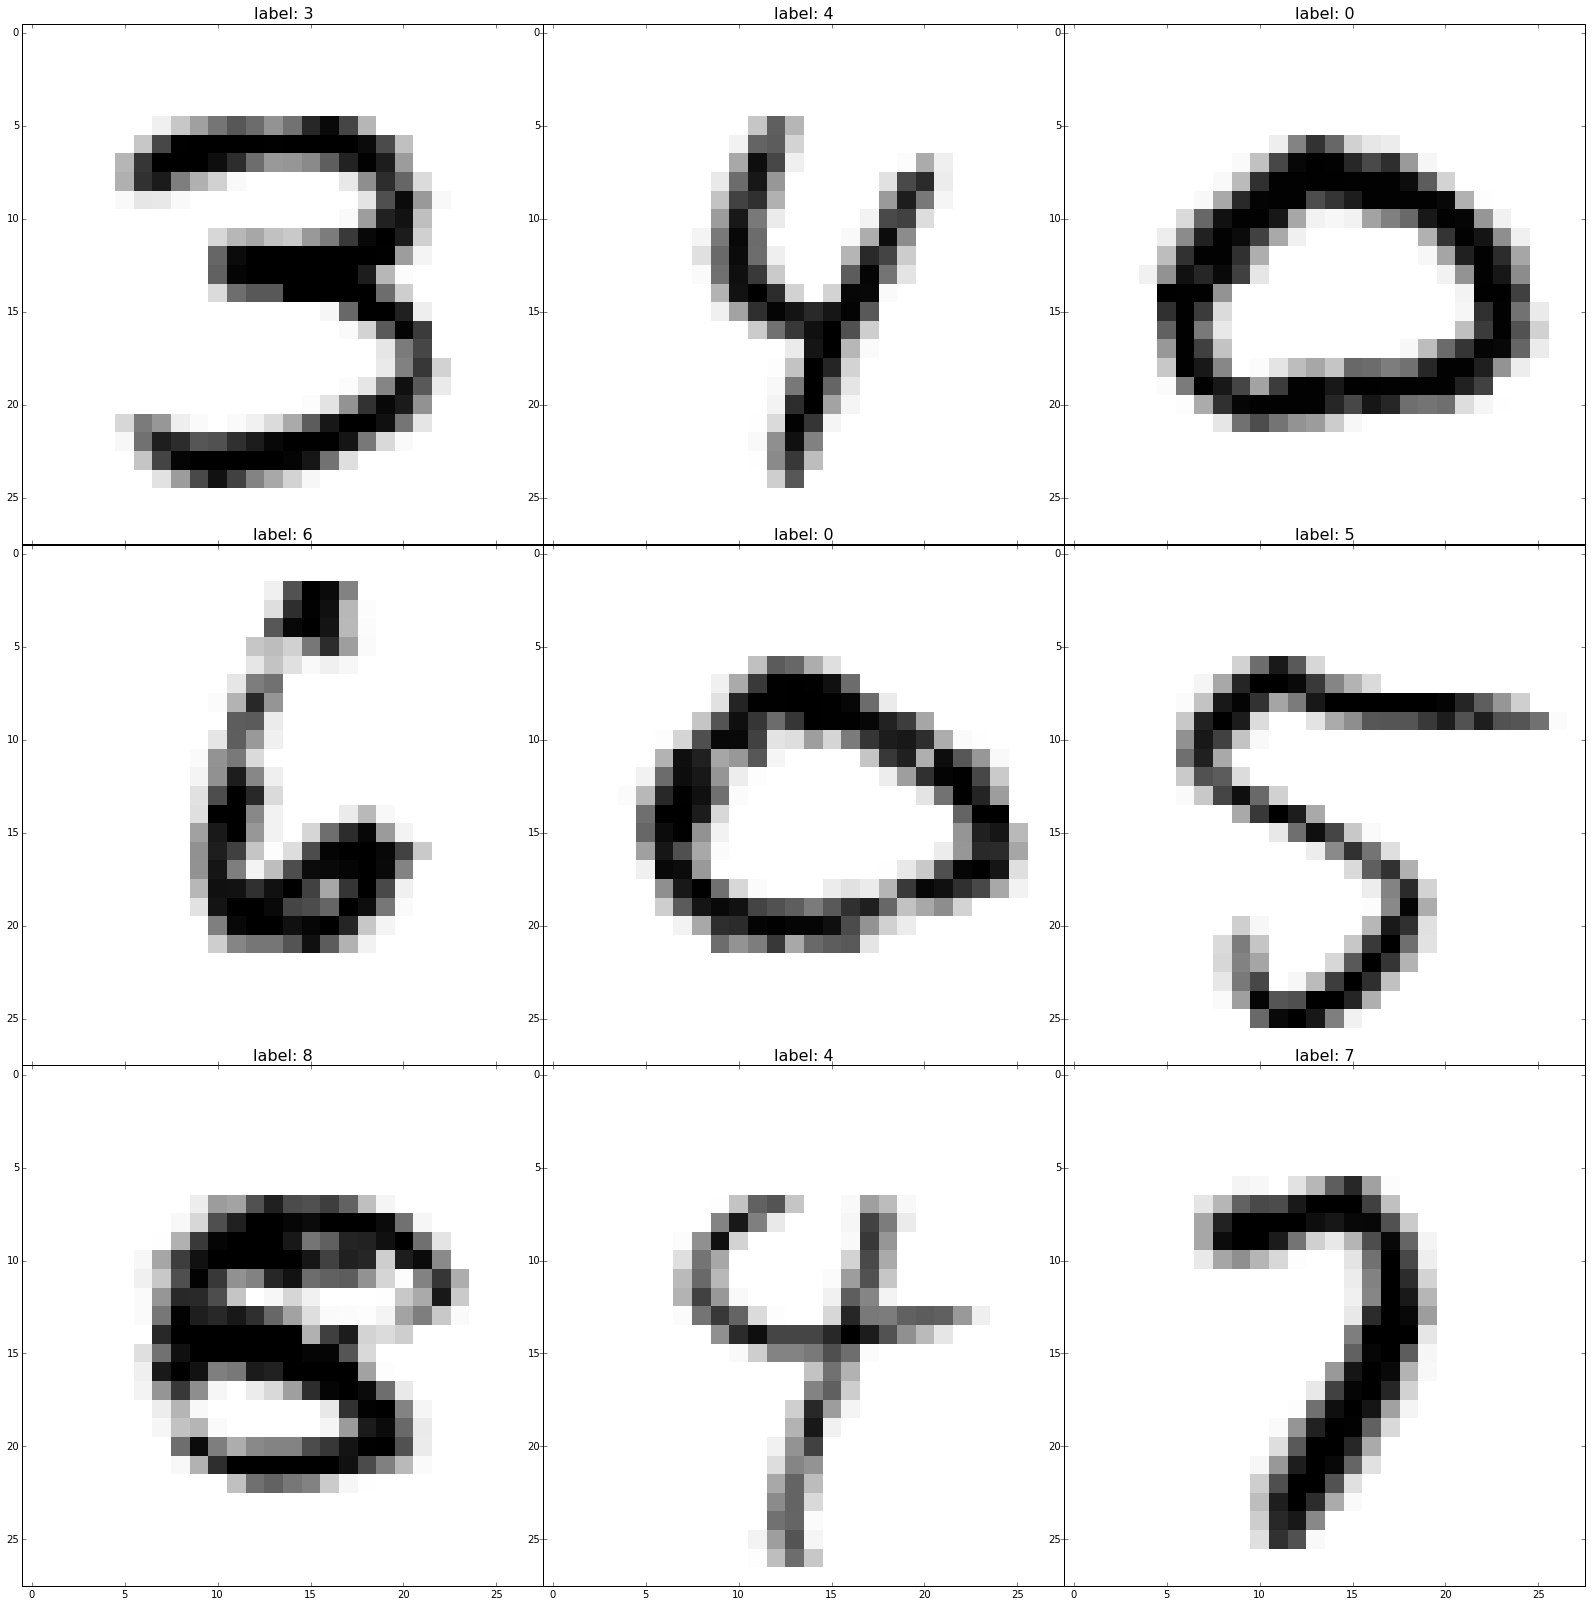

In [8]:
print_imgs(images           = trainX, 
           actual_labels    = trainY.ravel(), 
           predicted_labels = trainY.ravel(),#np.random.permutation(trainY), 
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 3)

***
#Plot the CV error-per-tree curves

##Set up the classifier's parameters

In [9]:
# default parameters for GradientBoostingClassifier
# =================================================
default_gbm_params = {}
default_gbm_params['loss'] = 'deviance'

default_gbm_params['learning_rate'] = 0.01 
default_gbm_params['n_estimators']  = 6000 

default_gbm_params['max_depth']      = 4     # fix the tree size
default_gbm_params['max_leaf_nodes'] = None  # choose tree size by deviance reduction
                                             # Note: these two are mutually exclusive

default_gbm_params['subsample']    = 0.5     # stochastic by observations
default_gbm_params['max_features'] = None    # stochastic by columns (similar to random forest)

default_gbm_params['min_samples_split'] = 2 
default_gbm_params['min_samples_leaf']  = 1 
#default_gbm_params['min_weight_fraction_leaf'] = 0.0

default_gbm_params['init']         = None 
default_gbm_params['random_state'] = 1009    # set a random seed
default_gbm_params['verbose']      = 0 
default_gbm_params['warm_start']   = False

# set parameters for the estimator
gbm_params = dict(default_gbm_params)

##Functions to find the score at each step ... parallelized

In [10]:
def heldout_score(clf, X_test, y_test, n_estimators):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_folds=3, params=gbm_params, X_train=trainX, y_train=trainY):
    """Calculate the average scores per tree fitted via 'n_folds' CV"""
    # stratified k-fold cv indexes
    SKFolds = StratifiedKFold(y            = trainY.ravel(), 
                              n_folds      = n_folds, 
                              indices      = None, 
                              shuffle      = True, 
                              random_state = 1009)
    
    # K-Folds of this function will run in separate processes
    def cv_processes(train, test, out_q, params):
        """One fold of the CV; to be run in parallel"""
        cv_clf = GradientBoostingClassifier(**params)
        cv_clf.fit(X_train[train], y_train[train])
        out_q.put(heldout_score(cv_clf, X_train[test], y_train[test], params['n_estimators']))
    
    # the results of each process will be saved in this Queue
    out_q = multiprocessing.Queue()
    
    # set up and run K-Fold processes
    process_list = []
    
    for train, test in SKFolds:
        p = multiprocessing.Process(
                target=cv_processes,
                args=(train, test, out_q, params))
        process_list.append(p)
        p.start()
        
    # extract the results of each process from the Queue
    process_results = []
    
    for i in range(n_folds):
        process_results.append(out_q.get())
        
    for p in process_list:
        p.join()
        
    # return the K-Fold results
    return {'mean': np.mean(np.array(process_results),axis=0),
            'min':  np.min (np.array(process_results),axis=0),
            'max':  np.max (np.array(process_results),axis=0)}

##Compute the loss curve by n_folds-CV on the training set

In [11]:
t0 = time.time()

cv_score = cv_estimate(n_folds=5, params=gbm_params)

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

time in seconds 8375.88


##Plot the curve(s)


Minimum max  CV loss 278.28, trees 1507
Minimum mean CV loss 221.11, trees 1650
Minimum min  CV loss 176.68, trees 1665



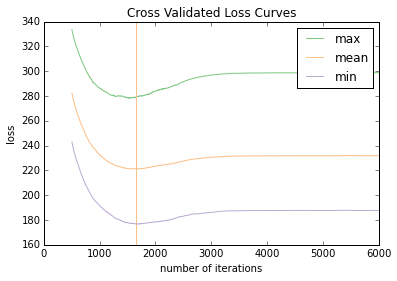

In [22]:
x = np.arange(gbm_params['n_estimators']) + 1

cv_max_iter  = x[np.argmin(cv_score['max'])]
cv_max_loss  = np.min(cv_score['max'])

cv_mean_iter = x[np.argmin(cv_score['mean'])]
cv_mean_loss = np.min(cv_score['mean'])

cv_min_iter  = x[np.argmin(cv_score['min'])]
cv_min_loss  = np.min(cv_score['min'])

print("\nMinimum max  CV loss {0:.2f}, trees {1}".format(cv_max_loss, cv_max_iter))
print("Minimum mean CV loss {0:.2f}, trees {1}".format(cv_mean_loss, cv_mean_iter))
print("Minimum min  CV loss {0:.2f}, trees {1}\n".format(cv_min_loss, cv_min_iter))

max_color  = list(map(lambda x: x / 256.0, (127, 201, 127)))
mean_color = list(map(lambda x: x / 256.0, (253, 192, 134)))
min_color  = list(map(lambda x: x / 256.0, (190, 174, 212)))

# skip the first third of the curves to focus on the section that reaches
# a minimum and then turns up with overfitting
one_third = math.floor(np.min([cv_min_iter, cv_mean_iter, cv_max_iter])/3)

plt.plot(x[one_third:], cv_score['max'][one_third:],  label='max',  color=max_color)
plt.plot(x[one_third:], cv_score['mean'][one_third:], label='mean', color=mean_color)
plt.axvline(x=cv_mean_iter,                 color=mean_color)
plt.plot(x[one_third:], cv_score['min'][one_third:],  label='min',  color=min_color)

plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('number of iterations')
plt.title('Cross Validated Loss Curves')

plt.show()

##4, 0.01, 1650 => minimum mean loss 221.11